In [1]:
import logging
import numpy as np
import pandas as pd
import geopandas
import glob
import os
from pyorbital import astronomy
from datetime import datetime, timedelta
from shapely import geometry

In [2]:
def compute_sun_glint_angle(sat_angle):
    """Compute the sun glint angle. Sun glint angle is defined as the angle difference between reflected solar beam and
    the satellite view/zenith angle, from the satellite reference frame. If the angle is small, it means that the
    reflected solar beam is seen by the satellite as sun glint.

    The eqn of sun glint is
        cos (theta_g) = cos (theta_v) * cos (theta_s) - sin (theta_v) * sin (theta_s) * cos (phi), where
        theta_g = sun glint angle, theta_v = satellite view/zenith angle, theta_s = solar zenith angle,
        phi = relative azimuth angle (difference between solar and satellite azimuth angle)

    For more info, refer to "An Enhanced Contextual Fire Detection Algorithm for MODIS" by Louis Giglio et al 2003
    https://doi.org/10.1016/S0034-4257(03)00184-6

    Args:
        sat_angle (dict): Dict of satellite angles: {
                        'viewzenang' (float): satellite view/zenith angle,
                        'solarzenang' (float): solar zenith angle,
                        'relazang' (float): relative azimuth angle ,
                         }

    Returns:
        sun_glint_angle (float): Angle of sun glint in degrees

    """
    theta_v = np.radians(sat_angle['viewzenang'])
    theta_s = np.radians(sat_angle['solarzenang'])
    phi = np.radians(sat_angle['relazang'])
    cos_sunglint = np.cos(theta_v) * np.cos(theta_s) - (np.sin(theta_v) * np.sin(theta_s) * np.cos(phi))
    sun_glint_rad = np.arccos(cos_sunglint)
    sun_glint_angle = np.degrees(sun_glint_rad)

    return sun_glint_angle

In [3]:
def parse_jaxa_hotspot_txt(file_path):
    """
    Parse the JAXA Himawari-8/9 AHI hotspot text and insert into the Pandas DataFrame
    with coordinates, fire radiative power, detection confidence, timestamp and satellite of hotspots.

    Args:
          file_path (str): File path to the JAXA Himawari-8/9 hotspot .csv
    """
    hs_ahi_df = pd.DataFrame()
    cols_to_use_list = [0, 2, *(i for i in range(7,27))]
    date_col_list = [0]
    names_list = ['date', 'satellite', 'lon', 'lat', 'viewzenang', 'viewazang', 'pixwid', 'pixlen', 't07',   
                  't14', 't07_t14', 'meant07', 'meant14', 'meandt', 'sdt07', 'sdt14', 'sddt', 
                  'ref3', 'ref4', 'fire_idx', 'fire', 'test1_6']
    
    print (len(names_list), len(cols_to_use_list))
    

    for file in glob.glob(file_path):
        try:
            f = open(file, "r")
            filename = os.path.basename(file)
            print(filename)
        except Exception as e:
            pass
        
        temp_hs_ahi_df = pd.read_csv(file, sep=",", skiprows=[0], \
                                     header=None, usecols=cols_to_use_list, \
                                     names=names_list, \
                                     parse_dates=date_col_list)

        temp_hs_ahi_df['confidence'] = 'NA'
        temp_hs_ahi_df['FRP'] = 'NA'
        temp_hs_ahi_df['satellite'] = 'Himawari-8/9'

        if len(temp_hs_ahi_df) > 0:
            try:
                temp_hs_ahi_df['solarazang'] = temp_hs_ahi_df.apply( \
                    lambda x: np.degrees(astronomy.get_alt_az(x['date'], x['lon'], x['lat'])[1]), axis=1)
                temp_hs_ahi_df['solarzenang'] = temp_hs_ahi_df.apply( \
                    lambda x: astronomy.sun_zenith_angle(x['date'], x['lon'], x['lat']), axis=1)
                temp_hs_ahi_df['relazang'] = temp_hs_ahi_df['solarazang'] - temp_hs_ahi_df['viewazang']
                temp_hs_ahi_df['sunglint_angle'] = temp_hs_ahi_df.apply(compute_sun_glint_angle, axis=1)
            except Exception as e:
                pass

            try:
                temp_hs_ahi_df.loc[(temp_hs_ahi_df['date'].dt.hour >= 0) \
                                   & (temp_hs_ahi_df['date'].dt.hour <= 11), 'daynight'] = 'day'
                temp_hs_ahi_df.loc[temp_hs_ahi_df['date'].dt.hour > 11, \
                                   'daynight'] = 'night'
                temp_hs_ahi_df['date'] = temp_hs_ahi_df['date'].dt.strftime( \
                    "%d/%m/%Y %H:%M:%S")
            except Exception as e:
                date_from_file = datetime.strptime(filename[4:17], "%Y%m%d_%H%M")
                temp_hs_ahi_df['date'] = date_from_file.strftime("%d/%m/%Y %H:%M:%S")

        hs_ahi_df = pd.concat([hs_ahi_df, temp_hs_ahi_df])

    if len(hs_ahi_df) > 0:
        hs_ahi_df = hs_ahi_df.reset_index(drop=True)

    return hs_ahi_df

In [4]:
hs_df = parse_jaxa_hotspot_txt(file_path="../data/raw/hotspots/ahi/*20190911_0[2-7]*.csv")

22 22
H08_20190911_0200_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0210_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0220_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0230_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0250_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0300_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0310_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0320_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0330_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0340_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0350_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0400_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0410_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0420_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0430_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0440_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0450_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0500_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0510_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0520_L2WLFbet_FLDK.06001_06001.csv
H08_20190911_0530_L2WLFbet_FLDK.06

In [5]:
end_dt = datetime(year=2019, month=9, day=11, hour=7, minute=30)
start_dt = datetime(year=2019, month=9, day=11, hour=2, minute=30)

In [6]:
filter_bool = (hs_df['date'] <= end_dt.strftime(format='%d/%m/%Y %H:%M:00')) & (hs_df['date'] >= start_dt.strftime(format='%d/%m/%Y %H:%M:00'))

In [7]:
hs_df_short = hs_df[filter_bool]

In [8]:
hs_df_short.reset_index(inplace=True, drop=True)

In [9]:
hs_gdf = geopandas.GeoDataFrame(hs_df_short, geometry=geopandas.points_from_xy(hs_df_short.lon, hs_df_short.lat))

In [10]:
hs_gdf.crs = {'init': 'epsg:4326'}
hs_gdf = hs_gdf.to_crs({'init': 'epsg:3857'})
hs_gdf.geometry = hs_gdf.buffer(1)
hs_gdf.head()

RuntimeError: b'no arguments in initialization list'

In [11]:
truth_df = pd.read_csv('../references/qgis_verification/Sep2019/Sep2019_groundtruth.csv')

In [12]:
truth_df.drop(columns=["Unnamed: 0"], inplace=True)
truth_gdf = geopandas.GeoDataFrame(truth_df, geometry=geopandas.points_from_xy(truth_df.lon, truth_df.lat))

In [13]:
truth_gdf.crs = {'init' :'epsg:4326'}
truth_gdf = truth_gdf.to_crs({'init': 'epsg:3857'})

In [14]:
truth_gdf_b500 = truth_gdf.buffer(500)

In [15]:
truth_gdf.geometry = truth_gdf_b500

In [16]:
truth_gdf.head()

,datestamp,geometry,lat,lon,end_date,start_date,period
0,2019/09/01,"POLYGON ((11371879.424 47734.603, 11371877.016...",0.428803,102.150839,2019-09-01,2019-09-01,0 days 00:00:00.000000000
1,2019/09/01,"POLYGON ((11372013.189 47386.805, 11372010.781...",0.425679,102.152041,2019-09-01,2019-09-01,0 days 00:00:00.000000000
2,2019/09/01,"POLYGON ((11400398.079 -14065.191, 11400395.67...",-0.126350,102.407027,2019-09-01,2019-09-01,0 days 00:00:00.000000000
3,2019/09/01,"POLYGON ((11399568.738 -13984.932, 11399566.33...",-0.125629,102.399577,2019-09-01,2019-09-01,0 days 00:00:00.000000000
4,2019/09/01,"POLYGON ((11400933.139 -14038.438, 11400930.73...",-0.126109,102.411833,2019-09-01,2019-09-01,0 days 00:00:00.000000000


In [17]:
clip_area = geopandas.read_file('../references/qgis_verification/shapefile/Sep_2019.shp')
clip_area.crs
clip_area = clip_area.to_crs({'init': 'epsg:3857'})

In [18]:
hs_df_clipped = geopandas.overlay(clip_area, hs_gdf, how='intersection')

In [19]:
hs_df_clipped.head()

,id,date,satellite,lon,lat,viewzenang,viewazang,pixwid,pixlen,t07,...,fire,test1_6,confidence,FRP,solarazang,solarzenang,relazang,sunglint_angle,daynight,geometry
0,1,11/09/2019 04:00:00,Himawari-8/9,103.96,-1.3,42.61,88.29,69.353,94.233,317.01,...,1,'001000',NA,NA,68.479144,16.374637,-19.810856,58.226437,day,"POLYGON ((11572775.263 -144727.756, 11572775.2..."
1,1,11/09/2019 04:10:00,Himawari-8/9,104.06,-1.3,42.50,88.28,69.231,93.901,329.70,...,1,'011000',NA,NA,64.614400,13.987077,-23.665600,55.538154,day,"POLYGON ((11583907.212 -144727.756, 11583907.2..."
2,1,11/09/2019 06:40:00,Himawari-8/9,104.02,-1.3,42.55,88.23,69.287,94.051,330.82,...,1,'011000',NA,NA,-76.374005,25.492991,-164.604005,18.991178,day,"POLYGON ((11579454.432 -144727.756, 11579454.4..."
3,1,11/09/2019 05:30:00,Himawari-8/9,104.04,-1.3,42.52,88.25,69.253,93.961,351.44,...,1,'011000',NA,NA,-50.821216,9.440320,-139.071216,35.824699,day,"POLYGON ((11581680.822 -144727.756, 11581680.8..."
4,1,11/09/2019 03:40:00,Himawari-8/9,104.02,-1.3,42.54,88.30,69.275,94.021,323.96,...,1,'001000',NA,NA,73.348975,21.049041,-14.951025,63.061925,day,"POLYGON ((11579454.432 -144727.756, 11579454.4..."


In [20]:
truth_gdf['id_truth'] = truth_gdf.index
truth_gdf.head()

,datestamp,geometry,lat,lon,end_date,start_date,period,id_truth
0,2019/09/01,"POLYGON ((11371879.424 47734.603, 11371877.016...",0.428803,102.150839,2019-09-01,2019-09-01,0 days 00:00:00.000000000,0
1,2019/09/01,"POLYGON ((11372013.189 47386.805, 11372010.781...",0.425679,102.152041,2019-09-01,2019-09-01,0 days 00:00:00.000000000,1
2,2019/09/01,"POLYGON ((11400398.079 -14065.191, 11400395.67...",-0.126350,102.407027,2019-09-01,2019-09-01,0 days 00:00:00.000000000,2
3,2019/09/01,"POLYGON ((11399568.738 -13984.932, 11399566.33...",-0.125629,102.399577,2019-09-01,2019-09-01,0 days 00:00:00.000000000,3
4,2019/09/01,"POLYGON ((11400933.139 -14038.438, 11400930.73...",-0.126109,102.411833,2019-09-01,2019-09-01,0 days 00:00:00.000000000,4


In [21]:
overlaid_gdf_ungrp = geopandas.overlay(truth_gdf, hs_df_clipped, how='union')
overlaid_gdf_ungrp.head()

,datestamp,lat_1,lon_1,end_date,start_date,period,id_truth,id,date,satellite,...,fire,test1_6,confidence,FRP,solarazang,solarzenang,relazang,sunglint_angle,daynight,geometry
0,2019/09/01,-1.259534,104.00183,2019-09-01,2019-09-01,0 days 00:00:00.000000000,10.0,1.0,11/09/2019 05:30:00,Himawari-8/9,...,1.0,'001000',NA,NA,-50.855072,9.384052,-139.165072,35.899131,day,"POLYGON ((11577228.043 -140273.865, 11577228.0..."
1,2019/09/08,-1.263210,104.00245,2019-09-08,2019-09-08,0 days 00:00:00.000000000,1554.0,1.0,11/09/2019 05:30:00,Himawari-8/9,...,1.0,'001000',NA,NA,-50.855072,9.384052,-139.165072,35.899131,day,"POLYGON ((11577228.043 -140273.865, 11577228.0..."
2,2019/09/01,-1.259534,104.00183,2019-09-01,2019-09-01,0 days 00:00:00.000000000,10.0,1.0,11/09/2019 07:00:00,Himawari-8/9,...,1.0,'001000',NA,NA,-78.607061,30.346000,-166.877061,14.441717,day,"POLYGON ((11577228.043 -140273.865, 11577228.0..."
3,2019/09/08,-1.263210,104.00245,2019-09-08,2019-09-08,0 days 00:00:00.000000000,1554.0,1.0,11/09/2019 07:00:00,Himawari-8/9,...,1.0,'001000',NA,NA,-78.607061,30.346000,-166.877061,14.441717,day,"POLYGON ((11577228.043 -140273.865, 11577228.0..."
4,2019/09/01,-1.259534,104.00183,2019-09-01,2019-09-01,0 days 00:00:00.000000000,10.0,1.0,11/09/2019 06:00:00,Himawari-8/9,...,1.0,'001000',NA,NA,-68.108354,15.915799,-156.408354,28.570955,day,"POLYGON ((11577228.043 -140273.865, 11577228.0..."


In [22]:
overlaid_gdf_ungrp['datestamp'].unique()

array(['2019/09/01', '2019/09/08', '2019/09/06', '2019/09/03',
       '2019/09/10', '2019/09/02', '2019/09/09', '2019/09/11',
       '2019/09/04', '2019/09/05', '2019/09/07', '2019/09/12', nan],
      dtype=object)

In [23]:
overlaid_gdf_ungrp = overlaid_gdf_ungrp[(overlaid_gdf_ungrp['datestamp'] == '2019/09/11') | overlaid_gdf_ungrp['datestamp'].isna()]

In [24]:
overlaid_gdf_ungrp['lat_1'].isna().sum()

11222

In [25]:
overlaid_gdf_ungrp['truth_flag'] = 1
overlaid_gdf_ungrp.loc[overlaid_gdf_ungrp['lat_2'].isna(), 'truth_flag'] = 0
overlaid_gdf_ungrp.loc[overlaid_gdf_ungrp['lat_1'].isna(), 'truth_flag'] = 0

In [26]:
%matplotlib inline
overlaid_gdf_ungrp['truth_flag'].describe()

count    12856.000000
mean         0.091630
std          0.288515
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: truth_flag, dtype: float64

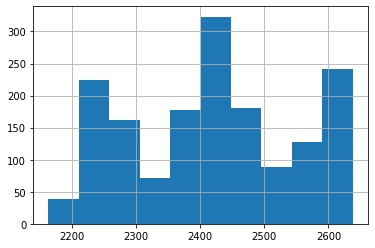

In [27]:
overlaid_gdf_ungrp['id_truth'].hist()

In [28]:
final_gdf = overlaid_gdf_ungrp.dropna(axis=0, subset=['truth_flag'])

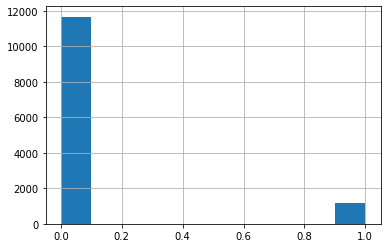

In [29]:
final_gdf['truth_flag'].hist()

In [30]:
predict_features = ['t07', 't14', 't07_t14', 'meant07', 'meant14', 'meandt', 'sdt07', 'sdt14', 'sddt', 'ref3', 'ref4', 'sunglint_angle']
final_gdf.dropna(subset=predict_features, inplace=True)

In [31]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = final_gdf[final_gdf.truth_flag==1]
df_minority = final_gdf[final_gdf.truth_flag==0]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample without replacement
                                 n_samples=len(df_majority),     # to match majority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_minority_upsampled, df_majority])

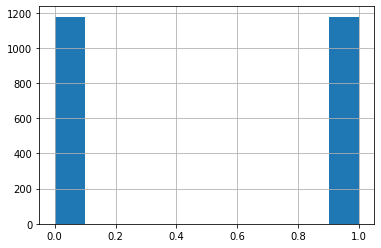

In [32]:
df_balanced['truth_flag'].hist()

In [33]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [34]:
logisticRegr = LogisticRegressionCV(fit_intercept=True, penalty='l1', solver='liblinear', cv=5, n_jobs=4)
#logisticRegr = svm.SVC(probability=True)

df_balanced[['t07', 't14', 't07_t14', 'meant07', 'meant14', 'meandt', 'sdt07', 'sdt14', 'sddt', 'ref3', 'ref4', 'sunglint_angle']].head()

,t07,t14,t07_t14,meant07,meant14,meandt,sdt07,sdt14,sddt,ref3,ref4,sunglint_angle
12281,319.55,301.13,18.42,306.0897,299.0022,7.0875,1.2570,1.6421,1.2852,0.095,0.228,15.723150
10045,339.16,303.00,36.16,306.8993,301.0446,5.8547,2.4935,1.3645,1.7722,0.074,0.318,41.010976
13917,320.27,298.84,21.43,302.3572,297.6195,4.7377,1.4687,1.0646,1.2936,0.129,0.171,16.898724
16462,317.04,295.69,21.35,302.0842,296.0839,6.0004,1.8035,2.0196,1.4083,0.258,0.338,10.091721
18484,334.78,306.79,27.99,305.4365,299.2411,6.1955,3.5972,5.1747,2.7268,0.052,0.101,12.398642


In [35]:
df_balanced.head()

,datestamp,lat_1,lon_1,end_date,start_date,period,id_truth,id,date,satellite,...,test1_6,confidence,FRP,solarazang,solarzenang,relazang,sunglint_angle,daynight,geometry,truth_flag
12281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,11/09/2019 07:10:00,Himawari-8/9,...,'011000',NA,NA,-79.322545,30.795187,-168.112545,15.723150,day,"POLYGON ((11356815.451 -104645.016, 11356815.4...",0
10045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,11/09/2019 05:10:00,Himawari-8/9,...,'011000',NA,NA,-19.413875,6.874644,-106.983875,41.010976,day,"POLYGON ((11577228.043 -202635.553, 11577228.0...",0
13917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,11/09/2019 07:20:00,Himawari-8/9,...,'011000',NA,NA,-80.354094,45.324495,-164.144094,16.898724,day,"POLYGON ((12679289.888 -347488.587, 12679289.8...",0
16462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,11/09/2019 06:20:00,Himawari-8/9,...,'011000',NA,NA,-75.994401,30.669362,-160.384401,10.091721,day,"POLYGON ((12688196.561 -314047.783, 12688196.5...",0
18484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,11/09/2019 06:20:00,Himawari-8/9,...,'011010',NA,NA,-74.076229,28.753003,-158.046229,12.398642,day,"POLYGON ((12452199.240 -369787.701, 12452199.2...",0


In [36]:
from sklearn.model_selection import cross_val_score

In [37]:
logisticRegr.fit(df_balanced[predict_features], df_balanced['truth_flag'])

C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=4, penalty='l1',
                     random_state=None, refit=True, scoring=None,
                     solver='liblinear', tol=0.0001, verbose=0)

In [38]:
for coeff, feature in zip(logisticRegr.coef_[0], predict_features):
    print (coeff, feature)

0.04675820588528067 t07
0.0 t14
0.013009572811010957 t07_t14
-0.03608338423061218 meant07
-0.016309204415502855 meant14
0.0 meandt
0.0 sdt07
0.0 sdt14
0.0 sddt
0.0 ref3
0.0 ref4
0.007849798633247312 sunglint_angle


In [47]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [48]:
y_prob = logisticRegr.predict_proba(df_balanced[predict_features])[:, 1]

In [49]:
fpr, tpr, thresholds = roc_curve(y_true = df_balanced['truth_flag'], y_score = y_prob)
csi = 1/((1/(1-fpr)) + (1/tpr) - 1)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [52]:
df_balanced['logit_proba'] = y_prob
df_balanced['sza_prob'] = 1
df_balanced.loc[df_balanced['sunglint_angle'] < 20, 'sza_prob'] = 0

In [53]:
roc = roc_auc_score(y_true = df_balanced['truth_flag'], y_score = y_prob)
roc_sg = roc_auc_score(y_true = df_balanced['truth_flag'], y_score = df_balanced['sza_prob'])

print (roc, roc_sg)

0.7498753318478846 0.4957555178268251


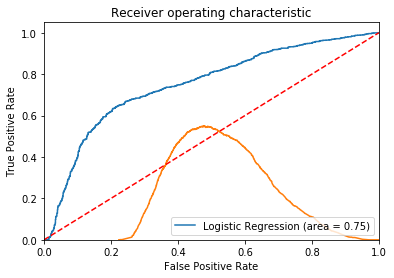

In [55]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc)
plt.plot(thresholds, csi)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

No handles with labels found to put in legend.


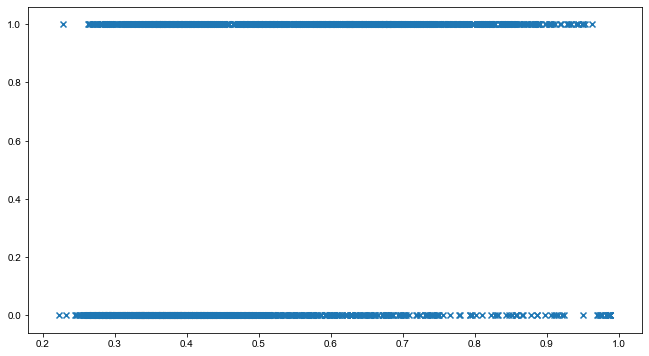

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(11,6))
ax = plt.axes()
plt.style.use('seaborn-whitegrid')
ax.scatter(df_balanced['logit_proba'], df_balanced['truth_flag'], marker='x');
ax.legend()

In [57]:
final_gdf['sza_prob'] = 1
final_gdf.loc[final_gdf['solarzenang'] < 20, 'sza_prob'] = 0

In [58]:
final_gdf['logit_prob'] = logisticRegr.predict_proba(final_gdf[predict_features])[:, 1]

In [59]:
hs_gdf['logit_prob'] = logisticRegr.predict_proba(hs_gdf[predict_features])[:, 1]

In [60]:
from sklearn.calibration import calibration_curve

In [61]:
prob_true, prob_pred = calibration_curve(final_gdf['truth_flag'], final_gdf['logit_prob'], n_bins=10)

No handles with labels found to put in legend.


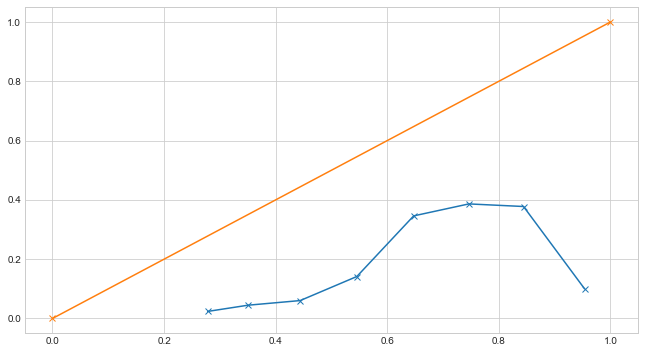

In [62]:
fig = plt.figure(figsize=(11,6))
ax = plt.axes()
plt.style.use('seaborn-whitegrid')
ax.plot(prob_pred, prob_true, marker='x');
ax.plot([0, 1], [0, 1], marker='x');
ax.legend()